<h1 style="text-align: center;">Analyis of Point Production of NBA Players</h1>

# Introduction

Using this dataset of NBA player stats we want to perform a regression analysis of the selected variables to help predict the on-court performance of a player (their average points scored). To do so, all non-preformance related stats, including, age,  height, weight, and draft pick will be used. The season variable will also allow player preformances to be measured throughout time and compare NBA starts from all eras and styles of the game. All of these factors were selected because of their likelihood to correlate with stronger on-court performance.

Our question: How do our selected factors help to predict the individual performance of NBA players? 

To do this, we will use [this dataset](https://www.kaggle.com/datasets/justinas/nba-players-data) from Kaggle. The data was acquired through the NBA API with missing information supplied by scraping from another NBA source (for this reason, the dataset was taken directly from Kaggle and not the original source). 

# Methods and Results

## Load Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Dataset Load & Preperation

First we pull our dataset from the internet.

The dataset contains 22 variables, the majority of which we need to discard as being impractical to use, having little impact on player performance (player name) or being directly related to a performance variable. We will conduct analysis on the remaining selected variables to try and predict the average points a player will get per season using regression analysis. By first training a model on the training data for each respective datapoint category we will then be able to analyze the knn regression and decide which of the columns is most effective at indicating points production.

In [2]:
url <-"https://raw.githubusercontent.com/mdean808/dsci-100-group-project/b11c50b091b2c4a554a2b7ff8f9e568e081b0f3c/all_seasons.csv"


temp <- tempfile()


download.file(url, temp)
# read the dataset from temp file
player_data <- read_csv(temp)
head(player_data)

New names:
• `` -> `...1`
Rows: 12305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): player_name, team_abbreviation, college, country, draft_year, draf...
dbl (14): ...1, age, player_height, player_weight, gp, pts, reb, ast, net_ra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,⋯,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,Dennis Rodman,CHI,36,198.12,99.79024,Southeastern Oklahoma State,USA,1986,2,⋯,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28,215.90,117.93392,Florida,USA,1990,1,⋯,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39,205.74,95.25432,Detroit Mercy,USA,1979,3,⋯,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24,203.20,100.69742,UCLA,USA,1995,1,⋯,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34,205.74,108.86208,Villanova,USA,1985,1,⋯,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97
5,Eddie Johnson,HOU,38,200.66,97.52228,Illinois,USA,1981,2,⋯,8.2,2.7,1.0,4.1,0.034,0.126,0.220,0.541,0.102,1996-97


For our project, we will focus only on the specific parameters to judge the overall performance of an NBA player. 

Note that for `draft_round` players labeled as `Undrafted` were removed. Additionally, players drafted in or before 2000 are excluded, to keep the data used recent.

In [3]:
nba_players <- player_data |>
    filter(draft_year > 2000) |>
    select(age, player_height, player_weight, net_rating, draft_number, draft_round, pts) |>
    # remove undrafted players and convert draft_number to dbl
    filter(draft_round != "Undrafted") |>
    mutate(draft_round = as.numeric(draft_round)) |>
    mutate(draft_number = as.numeric(draft_number))
                
nba_players

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,player_height,player_weight,net_rating,draft_number,draft_round,pts
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,205.74,102.96538,-23.1,17,1,1.2
21,213.36,102.96538,-6.2,3,1,17.6
21,185.42,79.83219,-5.0,53,2,5.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
32,205.74,111.13004,4.5,13,1,7.6
24,193.04,94.80073,-5.3,1,1,10.8
28,193.04,99.79024,9.3,6,1,12.1


Now we will split the data into training and testing. We will use the training data to build our regression model and our testing data to test the validity of our model. 

In [4]:
set.seed("1234")
nba_players_split <- initial_split(nba_players, prop = 0.75, strata = pts)
nba_training <- training(nba_players_split)
nba_testing <- testing(nba_players_split)

nba_training

age,player_height,player_weight,net_rating,draft_number,draft_round,pts
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24,215.90,111.5836,-4.1,45,2,1.8
23,205.74,100.2438,-11.0,33,2,3.8
24,213.36,111.1300,-12.8,49,2,1.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
24,190.50,90.7184,0.3,11,1,13.8
29,195.58,103.8726,-0.4,36,2,19.1
23,200.66,104.3262,3.5,3,1,28.4


# Dataset Visualization

Now we will look at the correlation of multiple parameters compared with points. This will allow us to predict which parameters strongly influence overall points scored before we build our regression model. 

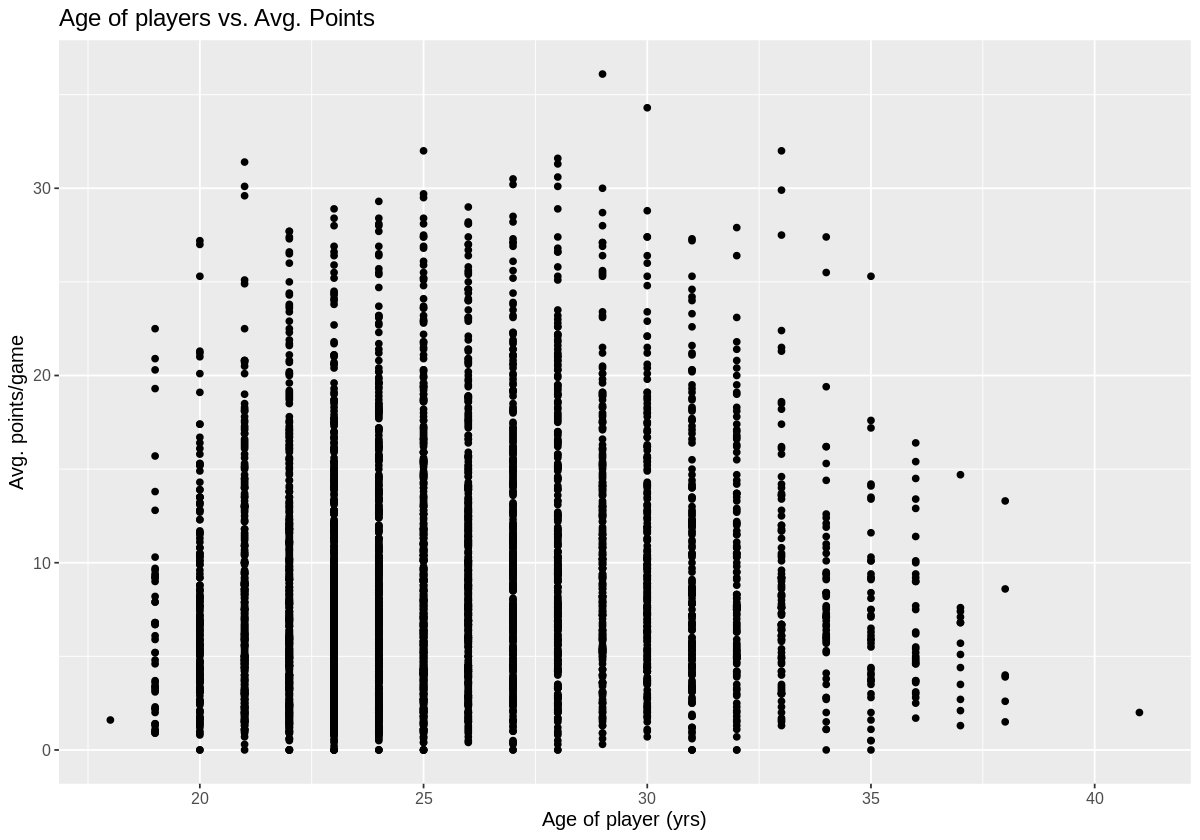

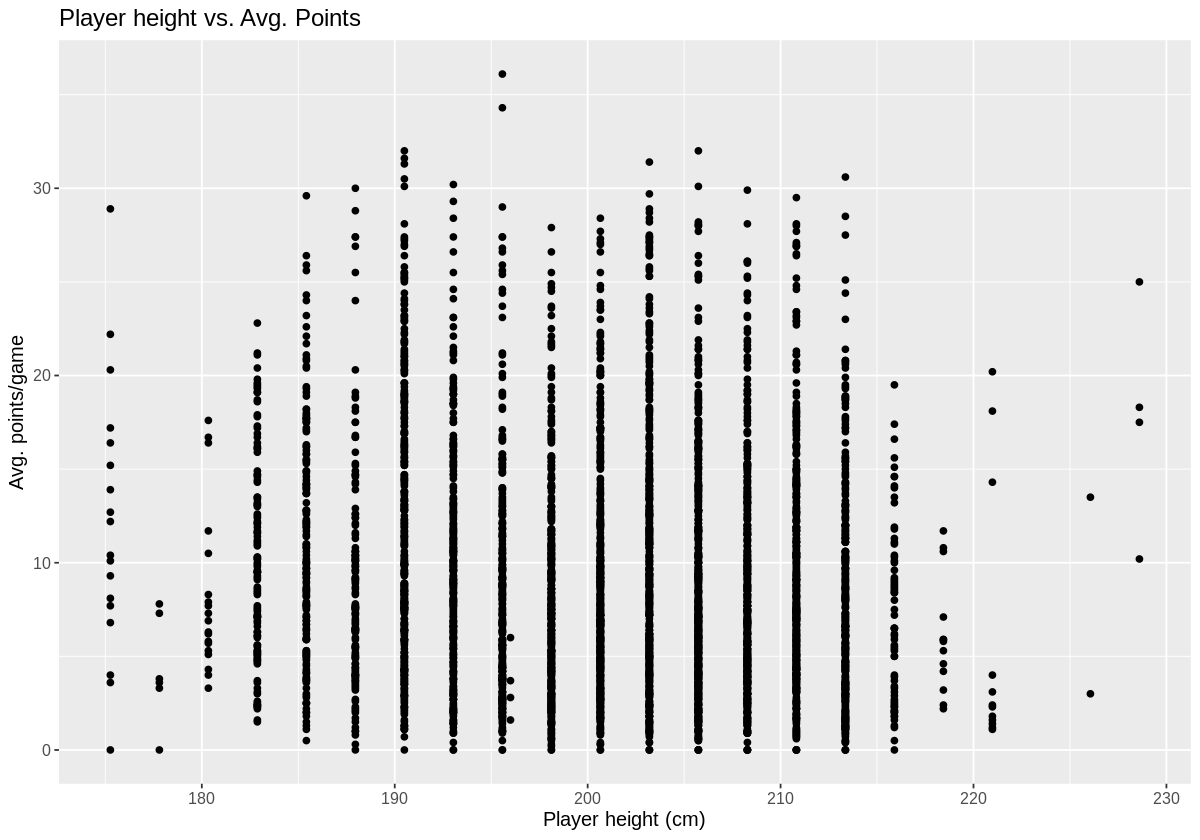

Warning message:
“Removed 3 rows containing missing values (geom_point).”


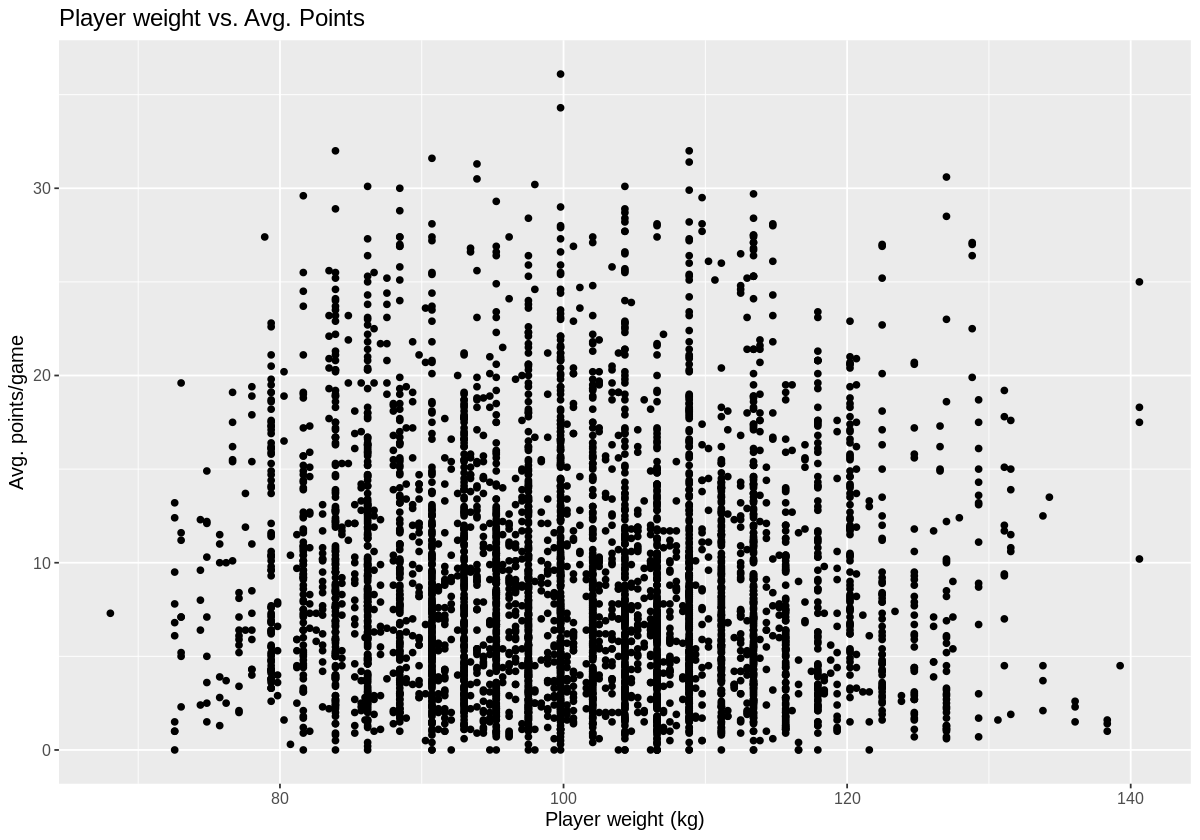

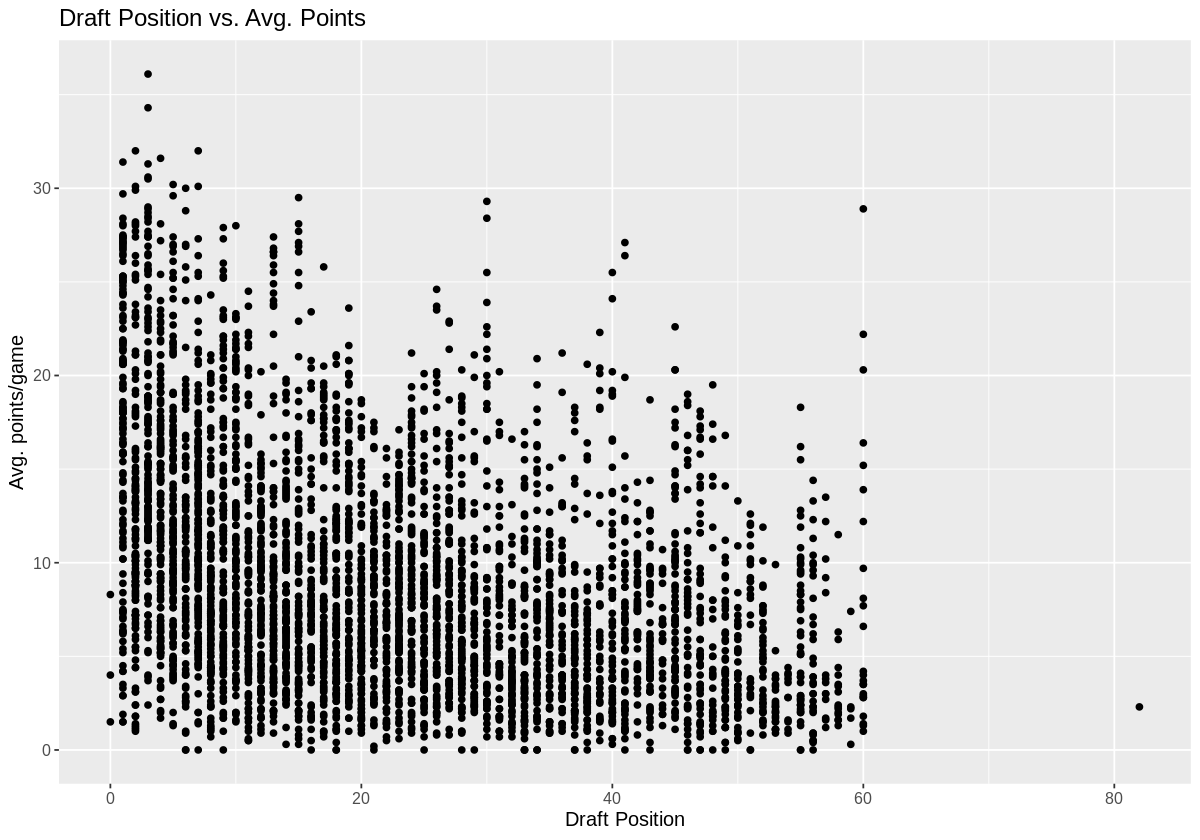

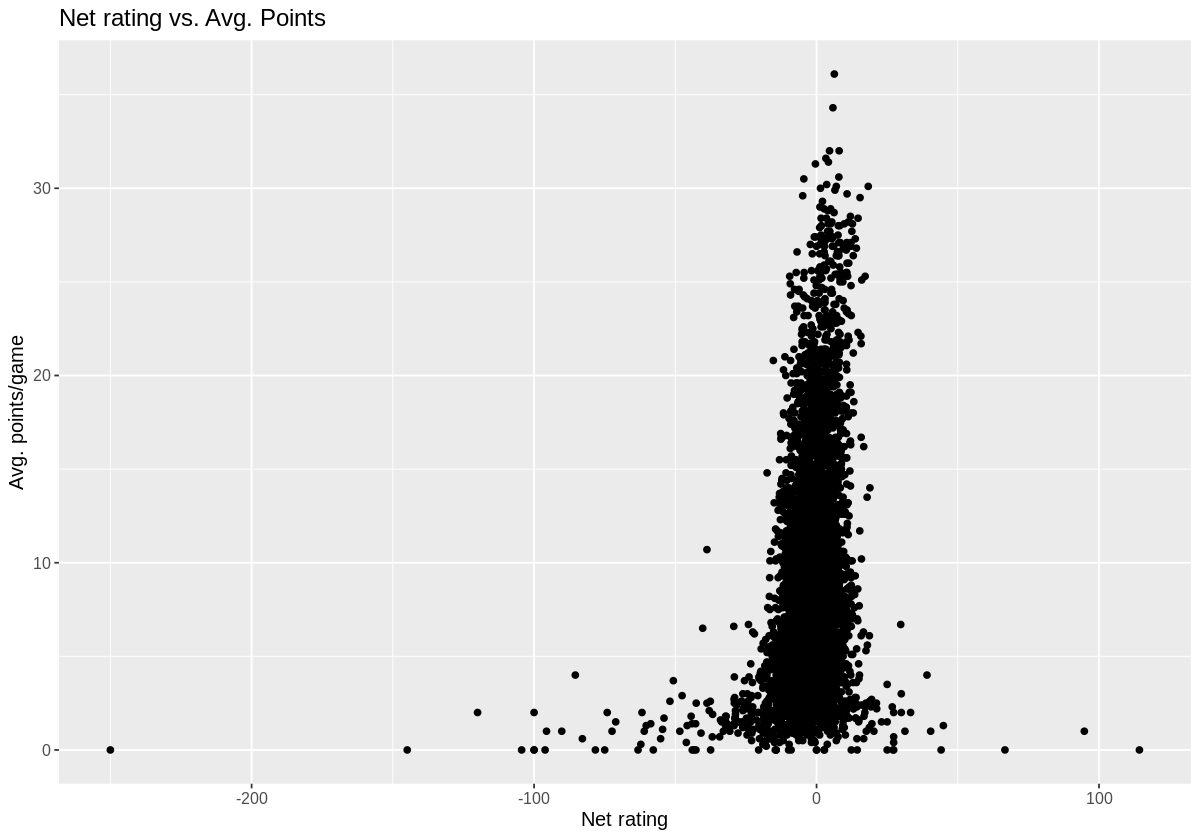

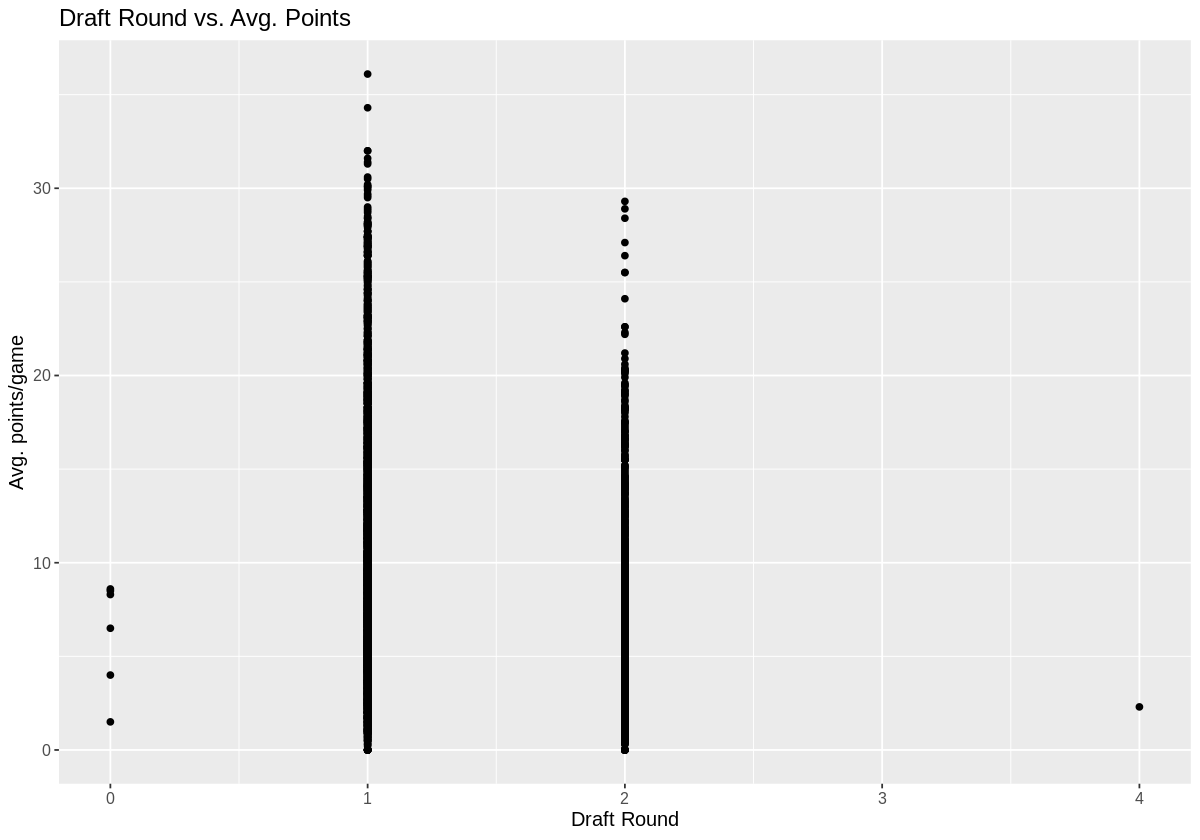

In [5]:
options(repr.plot.width = 10)

nba_plot_age <- ggplot(nba_training, aes(x = age, y = pts)) +
geom_point() +
labs(x = "Age of player (yrs)", y = "Avg. points/game") +
ggtitle("Age of players vs. Avg. Points") +
theme(text = element_text(size = 12))

nba_plot_height <- ggplot(nba_training, aes(x = player_height, y = pts)) +
geom_point() +
labs(x = "Player height (cm)", y = "Avg. points/game") +
ggtitle("Player height vs. Avg. Points") +
theme(text = element_text(size = 12))

nba_plot_weight <- ggplot(nba_training, aes(x = player_weight, y = pts)) +
geom_point() +
labs(x = "Player weight (kg)", y = "Avg. points/game") +
ggtitle("Player weight vs. Avg. Points") +
theme(text = element_text(size = 12))


nba_plot_number <- nba_training |>
mutate(draft_number = as.numeric(draft_number)) |>
ggplot(aes(x = draft_number, y = pts)) +
geom_point() +
labs(x = "Draft Position", y = "Avg. points/game") +
ggtitle("Draft Position vs. Avg. Points") +
theme(text = element_text(size = 12))


nba_plot_nr <- ggplot(nba_training, aes(x = net_rating, y = pts)) +
geom_point() +
labs(x = "Net rating", y = "Avg. points/game") +
ggtitle("Net rating vs. Avg. Points") +
theme(text = element_text(size = 12))


nba_plot_dr <- ggplot(nba_training, aes(x = draft_round, y = pts)) +
geom_point() +
labs(x = "Draft Round", y = "Avg. points/game") +
ggtitle("Draft Round vs. Avg. Points") +
theme(text = element_text(size = 12))

nba_plot_age
nba_plot_height
nba_plot_weight
nba_plot_number
nba_plot_nr
nba_plot_dr

As shown in the graphs, younger players and earlier draft position have positive correlation with average points. We expect these two parameters to be good predictors for performance. Basic information about the dataset is presented in the following table, consisting of the means for age, weight, height, draft number, as well as how many data points are contained in the set. 

In [6]:
summarise_age <- summarise(nba_training, mean_age = mean(age))
summarise_height <- summarise(nba_training, mean_height = mean(player_height))
summarise_weight <- summarise(nba_training, mean_weight = mean(player_weight))
summarise_nr <- summarise(nba_training, mean_nr = mean(net_rating))
summarise_nrow <- summarise(nba_training, total_rows = nrow(nba_training))

summarise_draft_number <- nba_training |>
summarise(mean_number = mean(as.numeric(draft_number), na.rm = TRUE))

summarise_draft_round <- nba_training |>
summarise(mean_round = mean(as.numeric(draft_round), na.rm = TRUE))



combined_summary <- bind_cols(summarise_age, summarise_weight, summarise_height, summarise_draft_number, summarise_nr, summarise_nrow, 
                             summarise_draft_round)


combined_summary



mean_age,mean_weight,mean_height,mean_number,mean_nr,total_rows,mean_round
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
25.65672,100.6858,201.1106,22.58598,-2.204734,4626,1.304583


## Data Analysis

To predict the player performance variable, we will be using k-nearest neighbors regression, as the relationships between the predictor variables and our performance variable are not all linear, and the performance variable is numeric.

First, we prepare the recipe by using the (scaled) age, player height, player weight, draft number, and draft round to predict the player's average points.

In [7]:
nba_recipe <- recipe(pts ~ age + player_height + player_weight + net_rating + draft_number + draft_round, data = nba_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

nba_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Then, we prepare the model. First, we will using tuning to determine the best number of neighbours to use, employing 5-fold cross-validation.

In [8]:
nba_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

nba_vfold <- vfold_cv(nba_training, v = 5, strata = pts)

nba_workflow <- workflow() |>
add_recipe(nba_recipe) |>
add_model(nba_spec)

nba_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Finally, we put it all together, using between 1 to 150 neighbours in increments of 5.

In [9]:
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 5))

nba_results <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results

nba_smallest <- nba_results |>
  filter(mean == min(mean))
nba_smallest


x Fold2: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 922 or 1, not 925.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,6.139999,4,0.08013819,Preprocessor1_Model01
6,rmse,standard,5.009307,4,0.04779691,Preprocessor1_Model02
11,rmse,standard,4.982103,4,0.02258877,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
136,rmse,standard,5.189716,4,0.05654379,Preprocessor1_Model28
141,rmse,standard,5.195907,4,0.05721629,Preprocessor1_Model29
146,rmse,standard,5.202368,4,0.05870658,Preprocessor1_Model30


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,rmse,standard,4.970096,4,0.02747729,Preprocessor1_Model04


Next, we prepare the final model, using the optimal amount of neighbors.

In [10]:
neighbors_val <- nba_smallest |>
pull(neighbors)

nba_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbors_val) |>
  set_engine("kknn") |>
  set_mode("regression")

nba_fit <- workflow() |>
  add_recipe(nba_recipe) |>
  add_model(nba_tuned_spec) |>
  fit(data = nba_training)

nba_predict <- nba_fit |>
  predict(nba_testing) |>
  bind_cols(nba_testing)



nba_rmse <- nba_predict |>
  metrics(truth = pts, estimate = .pred) |>
  filter(.metric == 'rmse')

nba_predict

nba_rmse

#head(nba_players |> arrange(pts, .desc = TRUE))

.pred,age,player_height,player_weight,net_rating,draft_number,draft_round,pts
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.28125,23,205.74,102.9654,-23.1,17,1,1.2
10.00000,21,213.36,102.9654,-6.2,3,1,17.6
8.70625,21,200.66,100.6974,-0.2,11,1,2.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
8.41875,32,203.20,98.88306,-4.8,14,1,15.4
9.84375,29,200.66,99.79024,-4.2,15,1,4.6
19.78750,28,193.04,99.79024,9.3,6,1,12.1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.809082


Due to the multiple variables used in prediction, the visualization for this prediction is difficult to produce. Instead, each variable used in the analysis is presented separately.

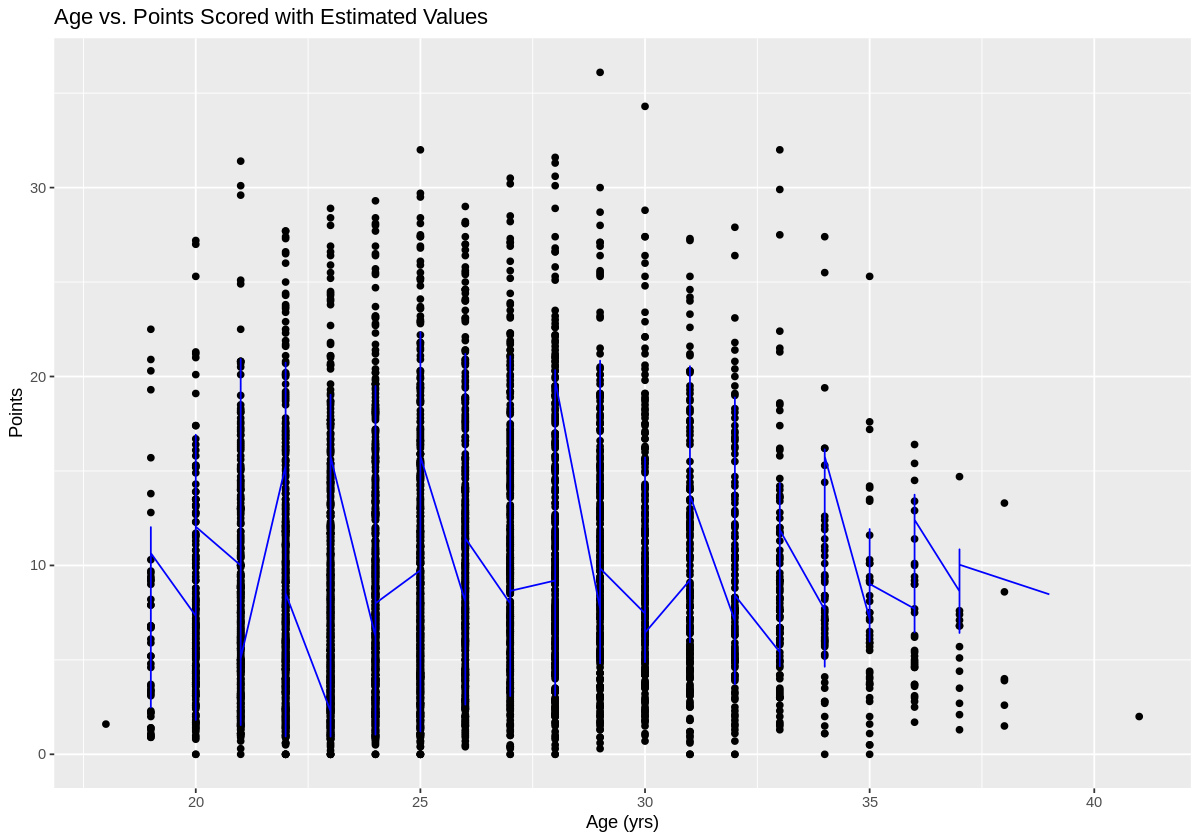

In [11]:
nba_predict_plot_age <- ggplot(nba_training, aes(x = age, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = age, y = .pred), color = 'blue') +
labs(x = "Age (yrs)", y = "Points") +
ggtitle("Age vs. Points Scored with Estimated Values")


nba_predict_plot_age

!!! Comments here

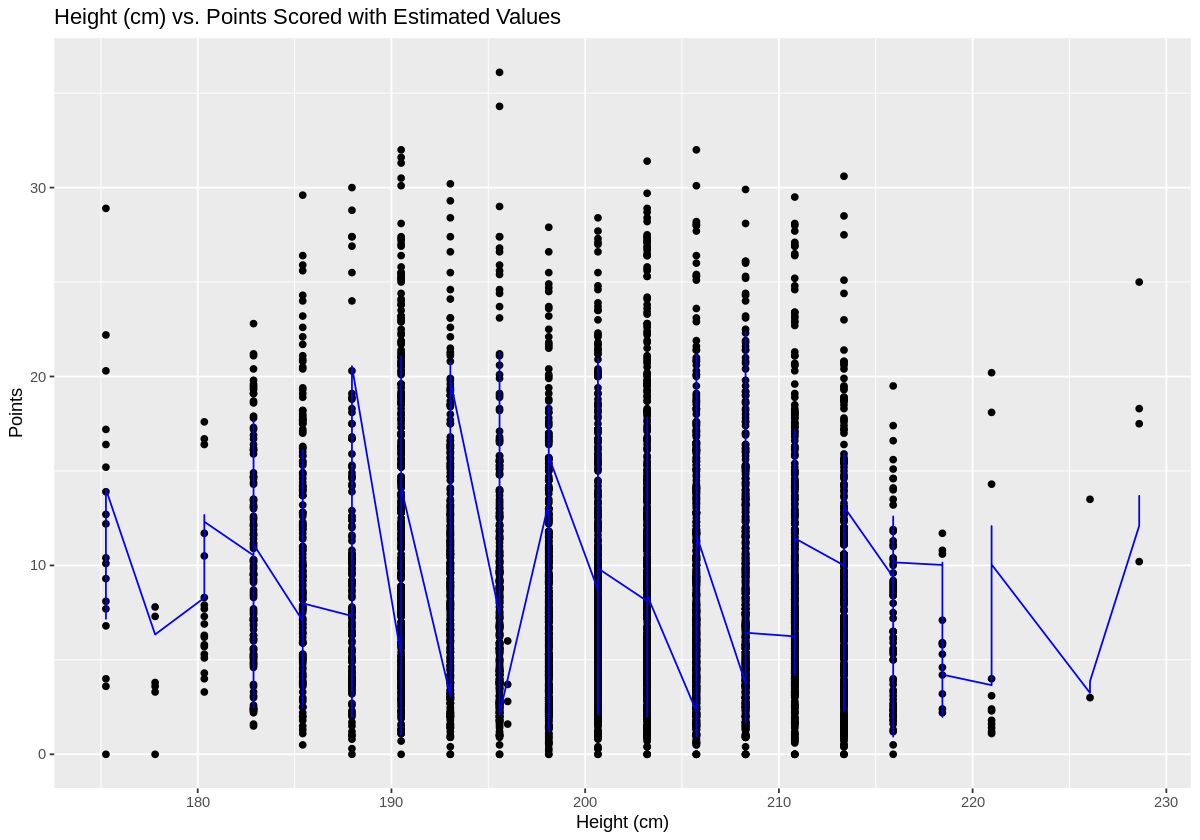

In [12]:
nba_predict_plot_height <- ggplot(nba_training, aes(x = player_height, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = player_height, y = .pred), color = 'blue') +
labs(x = "Height (cm)", y = "Points") +
ggtitle("Height (cm) vs. Points Scored with Estimated Values")

nba_predict_plot_height

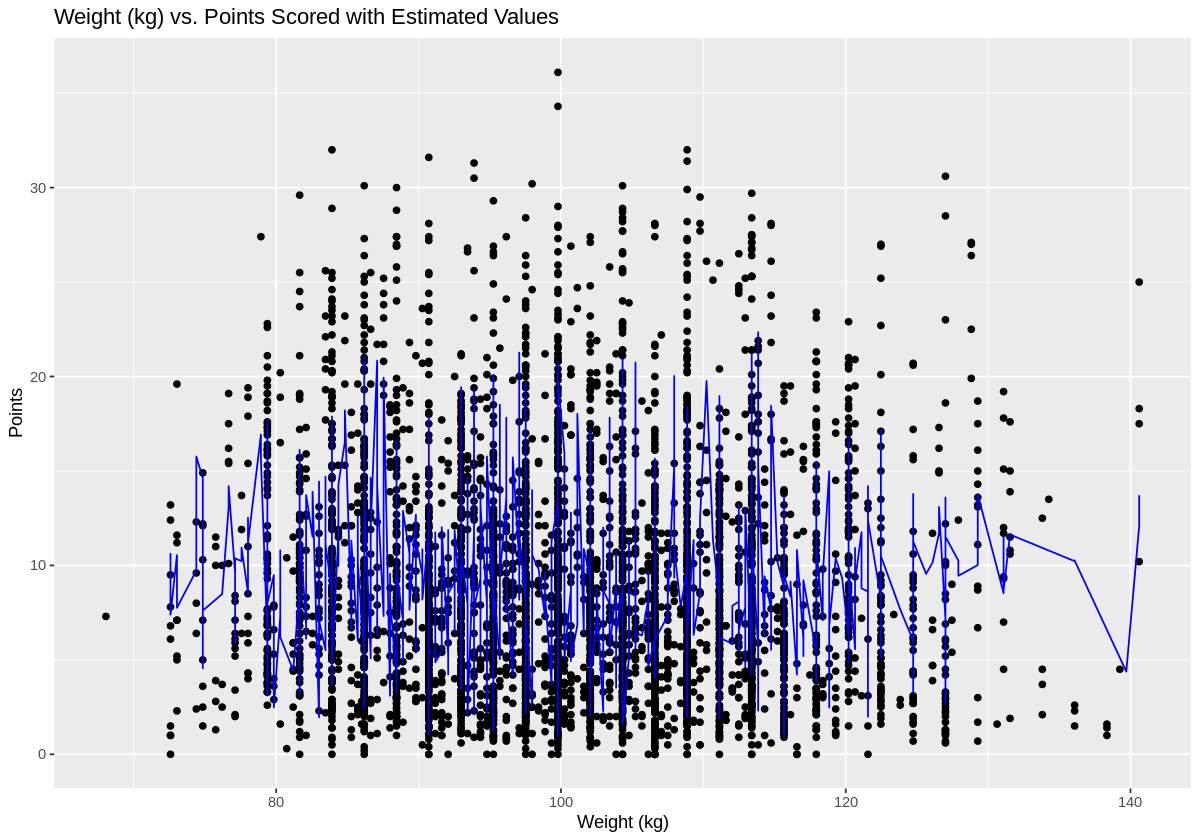

In [13]:
nba_predict_plot_weight <- ggplot(nba_training, aes(x = player_weight, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = player_weight, y = .pred), color = 'blue') +
labs(x = "Weight (kg)", y = "Points") +
ggtitle("Weight (kg) vs. Points Scored with Estimated Values")

nba_predict_plot_weight

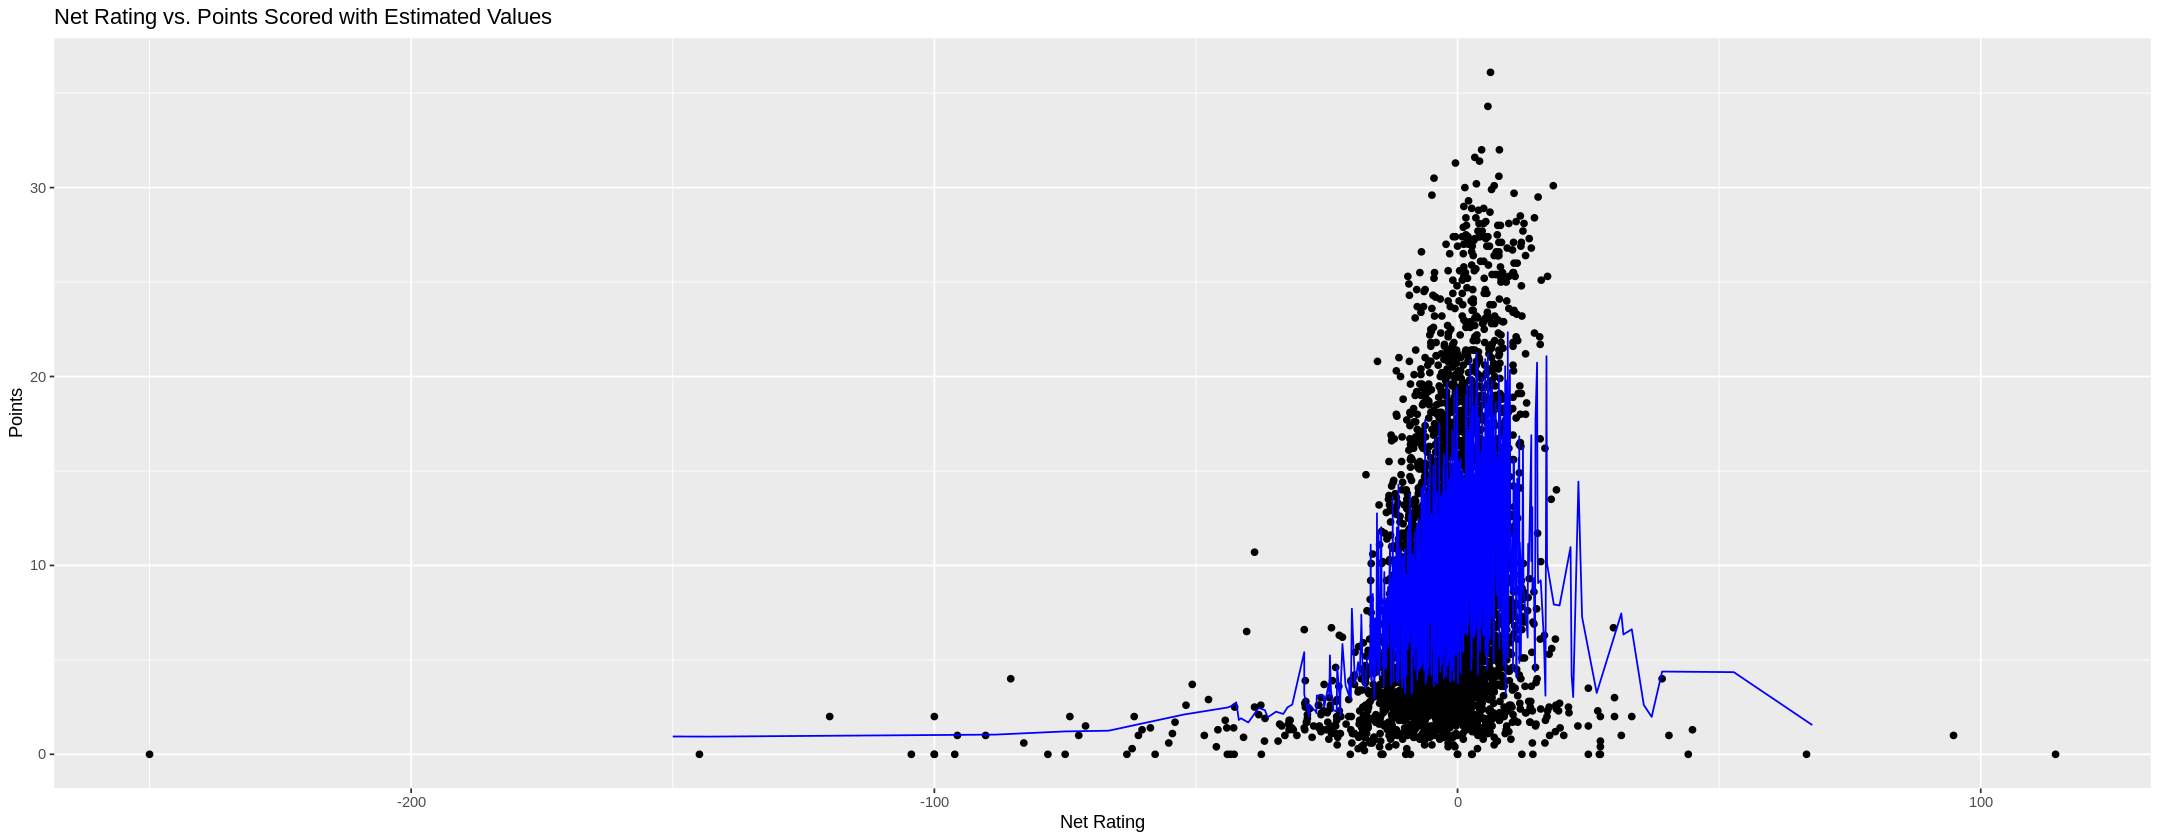

In [14]:
options(repr.plot.width = 18)

nba_predict_plot_nr <- ggplot(nba_training, aes(x = net_rating, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = net_rating, y = .pred), color = 'blue') +
labs(x = "Net Rating", y = "Points") +
ggtitle("Net Rating vs. Points Scored with Estimated Values")

nba_predict_plot_nr

Warning message:
“Removed 3 rows containing missing values (geom_point).”


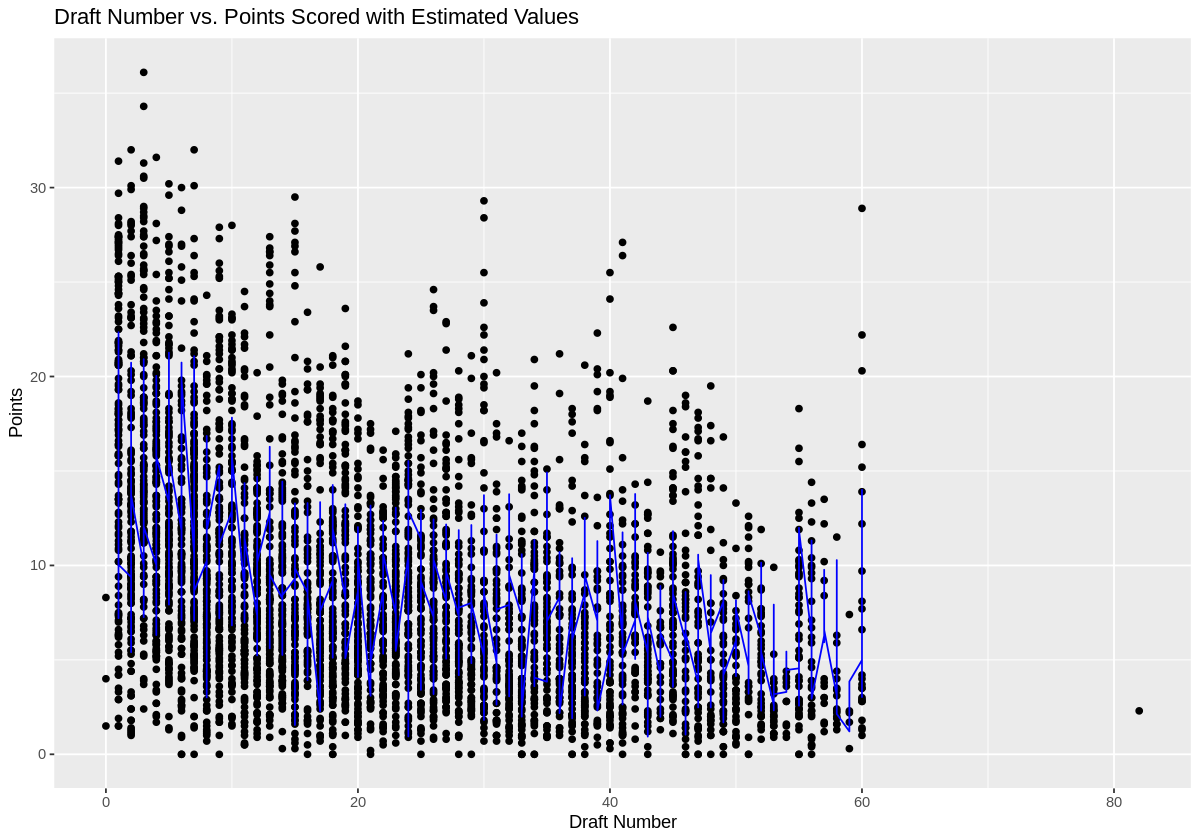

In [17]:
options(repr.plot.width = 10)
nba_predict_plot_dn <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = draft_number, y = .pred), color = 'blue') +
labs(x = "Draft Number", y = "Points") +
ggtitle("Draft Number vs. Points Scored with Estimated Values")

nba_predict_plot_dn

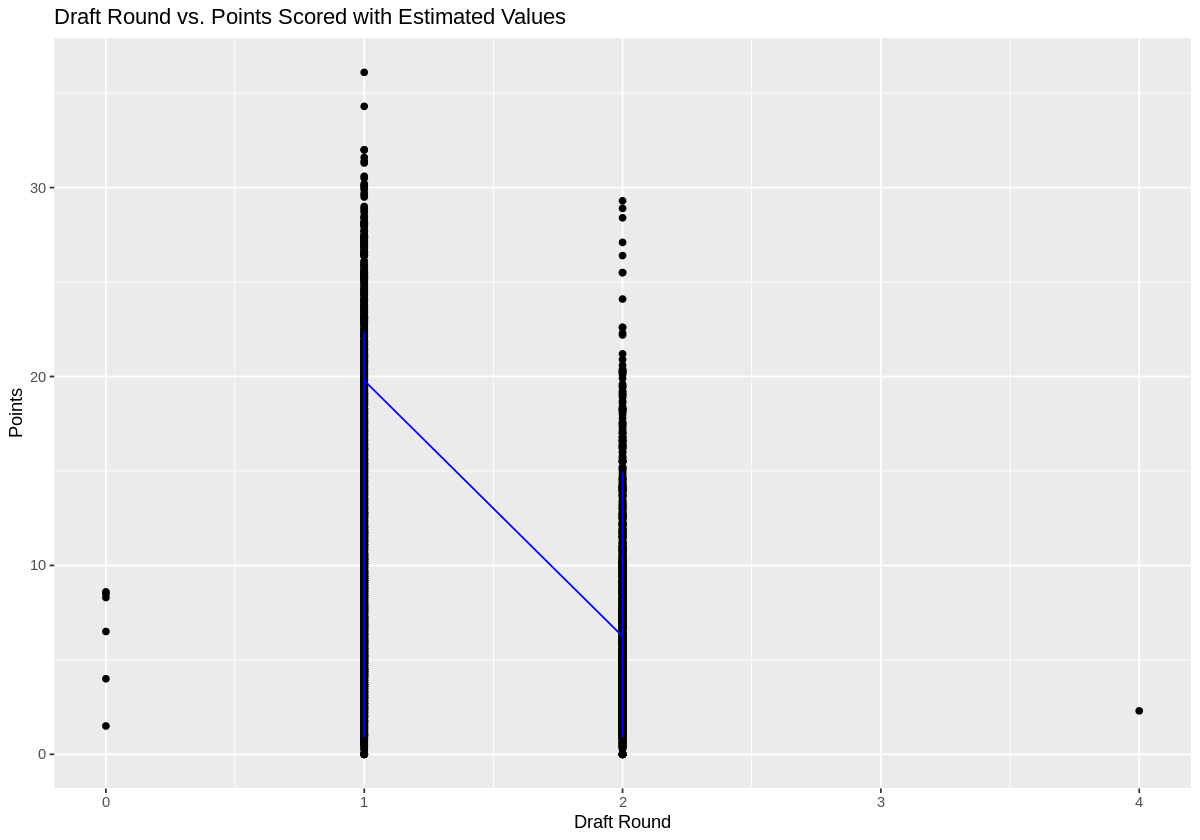

In [18]:

nba_predict_plot_dr <- ggplot(nba_training, aes(x = draft_round, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = draft_round, y = .pred), color = 'blue') +
labs(x = "Draft Round", y = "Points") +
ggtitle("Draft Round vs. Points Scored with Estimated Values")
nba_predict_plot_dr

# Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

# References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.